# Chapter 7: Semi-Supervised GAN

In [1]:
%matplotlib inline

from keras import backend as K

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


## Dataset

In [2]:
class Dataset:
    def __init__(self, num_labeled):
        
        # Number of examples to use as labeled for training
        self.num_labeled = num_labeled
        
        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        
        def preprocess_imgs(x):
            # Rescale to (-1, 1)
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)
     
        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        
        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels
    
    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs
    
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
    
    def test_set(self):
        return self.x_test, self.y_test

In [4]:
num_labeled = 100

dataset = Dataset(num_labeled)

11493376/11490434 [==============================] - 2s 0us/step


# Semi-Supervied GAN

In [5]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

## Generator

In [6]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(
                128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(
                64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(
                1, kernel_size=3, strides=2, padding='same'))

    # Tanh activation
    model.add(Activation('tanh'))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

## Discriminator

In [7]:
def build_discriminator_net(img_shape):
    
    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(Conv2D(32, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Droupout
    model.add(Dropout(0.5))
    
    # Flatten the tensor 
    model.add(Flatten())
    
    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))
    
    return model

In [8]:
def build_discriminator_supervised(discriminator_net):
    
    model = Sequential()
    
    model.add(discriminator_net)
    
    # Softmax giving probability distribution over the real classes
    model.add(Activation('softmax'))
    
    return model

In [9]:
def build_discriminator_unsupervised(discriminator_net):
    
    model = Sequential()
    
    model.add(discriminator_net)
    
    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction
    
    # Add the 'real-vs-fake' output neuron defined above
    model.add(Lambda(predict))
    
    return model

## Build the Model

In [10]:
# -------------------------
#  Build the Discriminator
# -------------------------

discriminator_net = build_discriminator_net(img_shape)

# Compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(
    loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

# Compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy', optimizer=Adam())

# ---------------------
#  Build the Generator
# ---------------------

generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Combined GAN model with fixed Discriminator to train the Generator
def combined(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

combined = combined(generator, discriminator_unsupervised)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [11]:
d_accuracies = []
d_losses = []

def train(iterations, batch_size, sample_interval):
    
    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------
        
        # Labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)
        
        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
        
        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
           
        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Train the Generator
        # ---------------------
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = combined.train_on_batch(z, np.ones((batch_size, 1)))
        
        # Save Discriminator supervised classification loss and accuracy to be plotted after training
        d_losses.append(d_loss_supervised)
        d_accuracies.append(accuracy)
        
        if iteration % sample_interval == 0:
            # Output training progress
            print ("%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]" % 
                   (iteration, d_loss_supervised, 100 * accuracy, d_loss_unsupervised, g_loss))

## Train the Model and Inspect Output

In [12]:
# Suppress warnings because the warning Keras gives us about non-trainable parameters is by design:
# The Generator trainable parameters are intentionally held constant during Discriminator training and vice versa
import warnings; warnings.simplefilter('ignore')

In [13]:
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

0 [D loss supervised: 3.2362, acc.: 3.12%] [D loss unsupervised: 1.7303] [G loss: 0.043378]
800 [D loss supervised: 0.0018, acc.: 100.00%] [D loss unsupervised: 0.2510] [G loss: 5.724998]
1600 [D loss supervised: 0.0005, acc.: 100.00%] [D loss unsupervised: 0.2163] [G loss: 5.001273]
2400 [D loss supervised: 0.0005, acc.: 100.00%] [D loss unsupervised: 0.1772] [G loss: 3.554047]
3200 [D loss supervised: 0.0012, acc.: 100.00%] [D loss unsupervised: 0.1978] [G loss: 5.677108]
4000 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.1704] [G loss: 4.383439]
4800 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.5801] [G loss: 2.624807]
5600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0621] [G loss: 6.756843]
6400 [D loss supervised: 0.0013, acc.: 100.00%] [D loss unsupervised: 0.0889] [G loss: 5.201848]
7200 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.1398] [G loss: 6.124498]


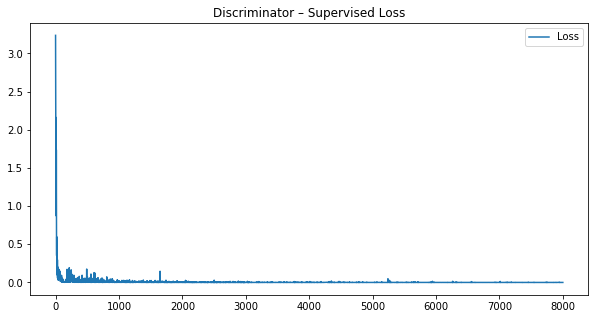

In [14]:
# Plot Discriminator supervised loss
plt.figure(figsize=(10,5))
plt.plot(np.array(d_losses), label="Loss")
plt.title("Discriminator – Supervised Loss")
plt.legend()

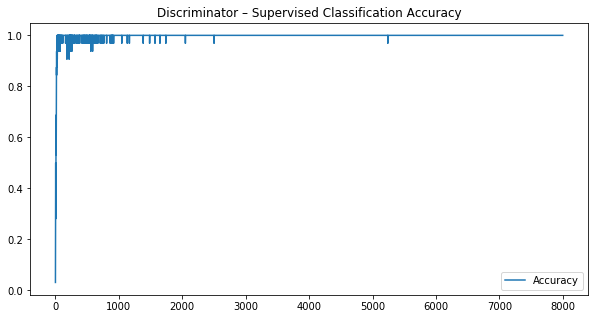

In [15]:
# Plot Discriminator accuracy
plt.figure(figsize=(10,5))
plt.plot(np.array(d_accuracies), label="Accuracy")
plt.title("Discriminator – Supervised Classification Accuracy")
plt.legend()

## SGAN Classifier – Training and Test Accuracy 

In [16]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

100/100 [==============================] - 0s 2ms/step
Training Accuracy: 100.00%


In [17]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 81us/step
Test Accuracy: 88.87%


---

# Fully-Supervised Classifier

In [18]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(
            loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

In [19]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs, y=labels, batch_size=32, epochs=50, verbose=1)
losses = training.history['loss']
accuracies = training.history['acc']

Epoch 1/50
100/100 [==============================] - 1s 8ms/step - loss: 2.7313 - acc: 0.1800
Epoch 2/50
100/100 [==============================] - 0s 315us/step - loss: 1.2495 - acc: 0.6000
Epoch 3/50
100/100 [==============================] - 0s 323us/step - loss: 0.7313 - acc: 0.8300
Epoch 4/50
100/100 [==============================] - 0s 305us/step - loss: 0.4006 - acc: 0.9000
Epoch 5/50
100/100 [==============================] - 0s 307us/step - loss: 0.3271 - acc: 0.9300
Epoch 6/50
100/100 [==============================] - 0s 315us/step - loss: 0.2153 - acc: 0.9600
Epoch 7/50
100/100 [==============================] - 0s 367us/step - loss: 0.1599 - acc: 0.9800
Epoch 8/50
100/100 [==============================] - 0s 323us/step - loss: 0.0983 - acc: 1.0000
Epoch 9/50
100/100 [==============================] - 0s 325us/step - loss: 0.1129 - acc: 0.9800
Epoch 10/50
100/100 [==============================] - 0s 302us/step - loss: 0.0839 - acc: 0.9900
Epoch 11/50
100/100 [==========

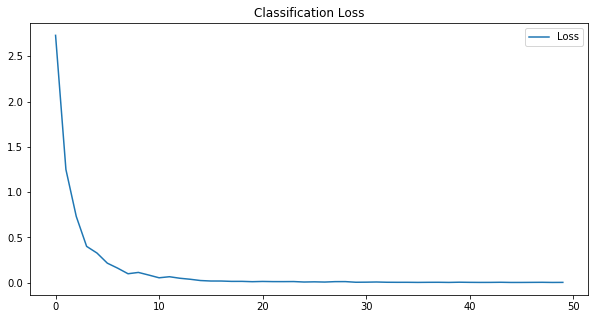

In [20]:
# Plot classification loss
plt.figure(figsize=(10,5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

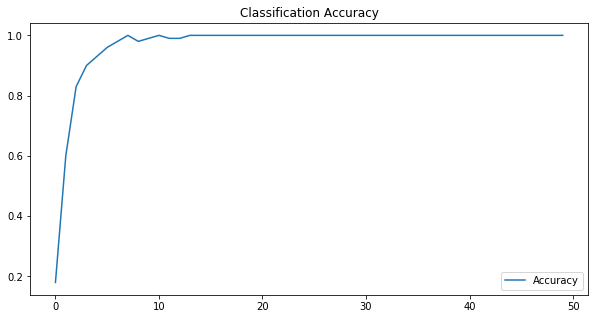

In [21]:
# Plot classification accuracy
plt.figure(figsize=(10,5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [22]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

100/100 [==============================] - 0s 2ms/step
Training Accuracy: 100.00%


In [23]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 82us/step
Test Accuracy: 70.07%


---